In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

# 定义网络，从nn.Module  继承
import torch
from torch import nn

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(len(x), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [2]:
model = LeNet5()
optimizer = torch.optim.Adam(model.parameters())
lossfunction = nn.CrossEntropyLoss()

In [3]:
def trainer(batch, model, optimizer, loss_func, device):
    # 将模型参数设为训练模式
    model.train()  # 训练中需要求模型参数的梯度，所有参数都处于可训练模式
    # 从batch中获取输入数据和标签(不一定有标签)
    x, y = batch
    # 将数据存入对应设备中
    x = x.to(device)
    y = y.to(device)
    # 梯度清零
    optimizer.zero_grad()
    # 前向传播
    y_hat = model(x)
    # 计算loss
    loss = loss_func(y_hat,y)   # 标量
    # 反向传播获取梯度
    loss.backward()
    # 更新参数
    optimizer.step()   # 更新一步

    # 计算准确率
    predictions = torch.argmax(y_hat, dim=1)  # 获取模型的预测结果
    correct_predictions = (predictions == y).sum().item()  # 统计正确的预测数量
    return loss.item() / y.shape[0], correct_predictions

In [4]:
def validate(val_loader, model, loss_func, device):
    # 将模型参数设为评估模式
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # 禁用梯度计算  （加速）比training速度快很多
        for batch in val_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            # 前向传播()
            y_hat = model(x)
            # 计算loss
            loss = loss_func(y_hat, y)

            total_loss += loss.item() / y.size(0)
            # 计算准确率
            predictions = torch.argmax(y_hat, dim=1)
            correct_predictions += (predictions == y).sum().item()
            total_samples += y.size(0)

    # 计算平均损失和准确率
    average_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples

    print(f"Validation Loss: {average_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")

    return average_loss, accuracy


In [6]:
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
import torchvision.transforms as T
# 定义数据集的转换
my_transform = T.Compose([  # 将两个函数组合
    T.ToTensor(),  # 将图像转换为张量
    T.Normalize((0.5,), (0.5,))  # 标准化张量，使其范围在[-1, 1]之间
])

# 初始化训练集和测试集
train_dataset = MNIST(root='./data', train=True, transform=my_transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=my_transform, download=True)

# 自定义数据集
class MyDataset(Dataset):
    def __init__(self):
        super().__init__()
        self.data = [0 for i in range(100)]

    def __getitem__(self, index):
        return self.data[i]

In [8]:
from torch.utils.data import DataLoader

# 定义 DataLoader 来加载数据
batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

array([<AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'9'}>,
       <AxesSubplot:title={'center':'2'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'4'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'5'}>,
       <AxesSubplot:title={'center':'3'}>,
       <AxesSubplot:title={'center':'6'}>,
       <AxesSubplot:title={'center':'1'}>,
       <AxesSubplot:title={'center':'7'}>,
       <AxesSubplot:title={'center':'2'}>,
       <AxesSubplot:title={'center':'8'}>], dtype=object)

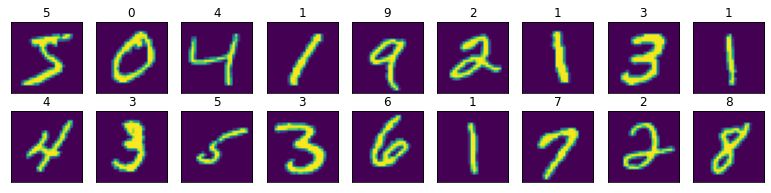

In [9]:
# 可视化训练集中前18
import matplotlib.pyplot as plt
def get_mnist_labels(labels):
    # 返回数据集的文本标签
    text_labels=['0','1','2','3','4','5','6'
                ,'7','8','9']
    return[text_labels[int(i)] for i in labels]

def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    #绘制图像列表
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=plt.subplots(num_rows,num_cols,figsize=figsize)
    axes=axes.flatten()
    for i,(ax,img)in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            #图片张量
            ax.imshow(img.numpy())
        else:
            #PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes
train_dataset.data[0].shape
X,y=next(iter(DataLoader(dataset=train_dataset,batch_size=18)))
show_images(X.reshape(18,28,28),2,9,titles=get_mnist_labels(y))

In [10]:
device = "cpu"
total_ep = 10
for ep in range(total_ep):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for batch in train_loader:
        loss, correct_predictions = trainer(batch, model, optimizer, lossfunction, device)
        total_loss += loss
        total_correct += correct_predictions
        total_samples += batch[1].shape[0]
    average_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    print(f"Epoch: {ep} Training Loss: {average_loss:.4f} | Accuracy: {accuracy * 100:.2f}%")
        
    if (ep+1) % 5 == 0:
        validate(test_loader, model, lossfunction, device)


Epoch: 0 Training Loss: 0.0022 | Accuracy: 82.19%
Epoch: 1 Training Loss: 0.0005 | Accuracy: 95.83%
Epoch: 2 Training Loss: 0.0003 | Accuracy: 97.46%
Epoch: 3 Training Loss: 0.0002 | Accuracy: 98.05%
Epoch: 4 Training Loss: 0.0002 | Accuracy: 98.38%
Validation Loss: 0.0002 | Accuracy: 98.31%
Epoch: 5 Training Loss: 0.0002 | Accuracy: 98.54%
Epoch: 6 Training Loss: 0.0001 | Accuracy: 98.81%
Epoch: 7 Training Loss: 0.0001 | Accuracy: 98.94%
Epoch: 8 Training Loss: 0.0001 | Accuracy: 99.03%
Epoch: 9 Training Loss: 0.0001 | Accuracy: 99.21%
Validation Loss: 0.0001 | Accuracy: 98.89%


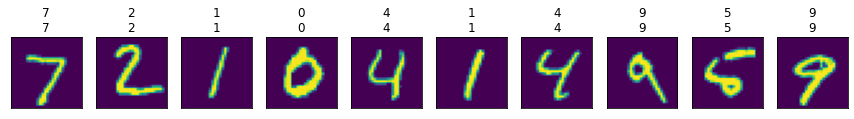

In [11]:
# 预测
def predict(model,test_loader,n=10):
    for X,y in test_loader:
        break
    trues=get_mnist_labels(y)
    preds=get_mnist_labels(model(X).argmax(axis=1))
    titles=[true+'\n'+pred for true,pred in zip(trues,preds)]
    show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])
    
predict(model,test_loader)